In [1]:
%matplotlib inline

In [2]:
import os
from pathlib import Path
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /home/p22g5


In [3]:
os.chdir('AnomaliesRecycling')
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /home/p22g5/AnomaliesRecycling



Transfer Learning
==============================================
Based on this [tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data)


In [121]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"  # specify which GPU(s) to be used

#torch.cuda.set_device(4)
cudnn.benchmark = True
plt.ion()   # interactive mode

In [122]:
torch.cuda.is_available()
#torch.cuda.current_device()

True

In [123]:
!ls ./data

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
test  train


Load Data
---------

In [124]:

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),

        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=(0, 180)),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
        transforms.RandomSolarize(threshold=0.5),
        transforms.RandomAdjustSharpness(sharpness_factor=50, p=0.5),

        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

batch_size = 4
data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

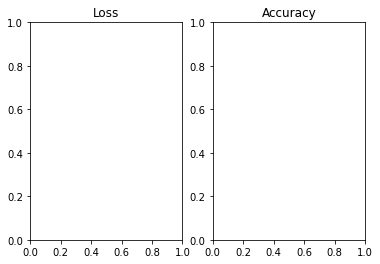

In [125]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax0 = fig.add_subplot(121, title="Loss")
ax1 = fig.add_subplot(122, title="Accuracy")

y_loss = {}  # loss history
y_loss['train'] = []
y_loss['test'] = []
y_acc = {}
y_acc['train'] = []
y_acc['test'] = []
x_epoch = []

def draw_curve(current_epoch, model_name):
    x_epoch.append(current_epoch)
    ax0.plot(x_epoch, y_loss['train'], 'bo-', label='train')
    ax0.plot(x_epoch, y_loss['test'], 'ro-', label='test')
    ax1.plot(x_epoch, [x.cpu() for x in y_acc['train']], 'bo-', label='train')
    ax1.plot(x_epoch, [x.cpu() for x in  y_acc['test']], 'ro-', label='test')
    if current_epoch == 0:
        ax0.legend()
        ax1.legend()
    folder = os.path.join('./lossGraphs', model_name)
    Path(folder).mkdir(exist_ok=True)
    fig.savefig(os.path.join(folder, 'train.jpg'))
    return fig

Visualize a few images



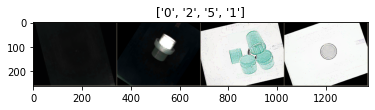

In [126]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

In [129]:
from torch.autograd import Variable

def train_model(model, criterion, optimizer, scheduler, writer, num_epochs=25, model_name=None):
    if not model_name:
        model_name = model.__class__.__name__
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                #inputs = inputs.to(device)
                #labels = labels.to(device)
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
            
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            y_loss[phase].append(epoch_loss)
            y_acc[phase].append(epoch_acc)

            # deep copy the model
            if phase == 'test':
                draw_curve(epoch, model_name)
                logger_losses = {"test_loss": y_loss['test'][epoch], "train_loss": y_loss['train'][epoch]}
                logger_acc = {"test_acc": y_acc['test'][epoch], "train_loss": y_acc['train'][epoch]}
                writer.add_scalars("losses", logger_losses, global_step=epoch)
                writer.add_scalars("accuracy", logger_acc, global_step=epoch)

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best test acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    path = "./models/" + model_name
    torch.save(model.state_dict(), path)
    writer.close()
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [130]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test'], 0):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted for {labels[j]}: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [137]:
#model_ft = models.mobilenet_v3_small(pretrained=True)
#model_ft = models.efficientnet_b7(pretrained=True)
model_ft = models.resnet18(pretrained=True)
#print(model_ft)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 6, since we have 6 classes
model_ft.fc = nn.Linear(num_ftrs, 6)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

In [138]:
from torch.utils.tensorboard import SummaryWriter
model_name = "ResNet18_Augm"
writer = SummaryWriter('runs/'+model_name)

***Train and evaluate***

In [139]:

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer, num_epochs=100, model_name=model_name)

Epoch 0/99
----------
train Loss: 0.7318 Acc: 0.7445
test Loss: 0.5522 Acc: 0.8421

Epoch 1/99
----------
train Loss: 0.4531 Acc: 0.8291
test Loss: 0.3628 Acc: 0.8675

Epoch 2/99
----------
train Loss: 0.4496 Acc: 0.8395
test Loss: 0.4352 Acc: 0.8657

Epoch 3/99
----------
train Loss: 0.4054 Acc: 0.8645
test Loss: 0.3327 Acc: 0.8838

Epoch 4/99
----------
train Loss: 0.3785 Acc: 0.8691
test Loss: 0.3387 Acc: 0.8657

Epoch 5/99
----------
train Loss: 0.3519 Acc: 0.8841
test Loss: 0.3099 Acc: 0.8947

Epoch 6/99
----------
train Loss: 0.3555 Acc: 0.8823
test Loss: 0.4092 Acc: 0.8711

Epoch 7/99
----------
train Loss: 0.3309 Acc: 0.8855
test Loss: 0.2967 Acc: 0.8929

Epoch 8/99
----------
train Loss: 0.3546 Acc: 0.8873
test Loss: 0.8088 Acc: 0.5172

Epoch 9/99
----------
train Loss: 0.3502 Acc: 0.8845
test Loss: 0.3471 Acc: 0.8929

Epoch 10/99
----------
train Loss: 0.3068 Acc: 0.8986
test Loss: 0.2932 Acc: 0.8911

Epoch 11/99
----------
train Loss: 0.2913 Acc: 0.9045
test Loss: 0.3426 Acc

In [38]:
!reload_ext tensorboard
!tensorboard --logdir runs

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: reload_ext: command not found
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.9.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


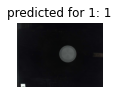

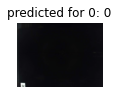

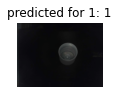

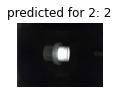

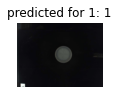

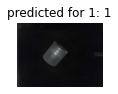

In [12]:
model_ft.load_state_dict(torch.load("./models/"+model_name))
visualize_model(model_ft)

***Filenames where validation failed***

In [35]:
batch_size = 4
model_ft.eval()
with torch.no_grad():
    for i, (input, label) in enumerate(image_datasets['test'], 0):
        #print(input)
        input = input.to(device)
        #label = label.to(device)

        output = model_ft(input.unsqueeze(0))
        _, pred = torch.max(output, 1)


        if label != pred:
            print(image_datasets['test'].imgs[i])
            #print(dataloaders['test'].dataset.samples[i*batch_size+j][0])
            print(f'must be {label}, but predicted {class_names[pred]}')



('data/test/0/Anlerndaten (622).jpg', 0)
must be 0, but predicted 1
('data/test/1/Anlerndaten (14).jpg', 1)
must be 1, but predicted 2
('data/test/1/Anlerndaten (804).jpg', 1)
must be 1, but predicted 2
('data/test/1/Anlerndaten (931).jpg', 1)
must be 1, but predicted 2
('data/test/2/Anlerndaten (255).jpg', 2)
must be 2, but predicted 1
('data/test/2/Anlerndaten (423).jpg', 2)
must be 2, but predicted 1
('data/test/2/Anlerndaten (596).jpg', 2)
must be 2, but predicted 1
('data/test/2/Anlerndaten (615).jpg', 2)
must be 2, but predicted 1
('data/test/2/Anlerndaten (669).jpg', 2)
must be 2, but predicted 1
('data/test/2/Anlerndaten (980).jpg', 2)
must be 2, but predicted 1
('data/test/2/trial (1013).jpg', 2)
must be 2, but predicted 1
('data/test/2/trial (1018).jpg', 2)
must be 2, but predicted 1
('data/test/2/trial (1326).jpg', 2)
must be 2, but predicted 1
('data/test/2/trial (1371).jpg', 2)
must be 2, but predicted 1
('data/test/2/trial (611).jpg', 2)
must be 2, but predicted 1
('data/

In [37]:
batch_size = 4
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test'], 0):
        #print(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        for j in range(inputs.size()[0]):
            #print(j)
            if labels[j] != preds[j]:
                print(dataloaders['test'].dataset.samples[i*batch_size+j][0])
                print(f'must be {labels[j]}, but predicted {class_names[preds[j]]}')



data/test/0/trial (279).jpg
must be 2, but predicted 1
data/test/0/trial (77).jpg
must be 2, but predicted 1
data/test/0/trial (957).jpg
must be 4, but predicted 3
data/test/0/trial (961).jpg
must be 2, but predicted 1
data/test/1/Anlerndaten (295).jpg
must be 1, but predicted 2
data/test/1/Anlerndaten (599).jpg
must be 2, but predicted 1
data/test/1/Anlerndaten (610).jpg
must be 2, but predicted 1
data/test/1/Anlerndaten (824).jpg
must be 5, but predicted 3
data/test/1/trial (1182).jpg
must be 3, but predicted 2
data/test/1/trial (1240).jpg
must be 2, but predicted 1
data/test/1/trial (1276).jpg
must be 3, but predicted 2
data/test/1/trial (1316).jpg
must be 2, but predicted 1
data/test/1/trial (1363).jpg
must be 0, but predicted 1
data/test/1/trial (1643).jpg
must be 2, but predicted 1
data/test/1/trial (246).jpg
must be 3, but predicted 2
data/test/1/trial (287).jpg
must be 3, but predicted 2
data/test/1/trial (498).jpg
must be 2, but predicted 1
data/test/1/trial (658).jpg
must be 

ConvNet as fixed feature extractor
----------------------------------

In [79]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 6)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [81]:
from torch.utils.tensorboard import SummaryWriter
model_name = "ResNet18_freezed"
writer = SummaryWriter('runs/'+model_name)
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, writer=writer, num_epochs=50, model_name=model_name)

Epoch 0/49
----------
train Loss: 0.8307 Acc: 0.6977
test Loss: 0.5755 Acc: 0.7786

Epoch 1/49
----------
train Loss: 0.7038 Acc: 0.7482
test Loss: 0.8494 Acc: 0.6987

Epoch 2/49
----------
train Loss: 0.6470 Acc: 0.7691
test Loss: 0.4865 Acc: 0.8221

Epoch 3/49
----------
train Loss: 0.5775 Acc: 0.7886
test Loss: 0.4508 Acc: 0.8530

Epoch 4/49
----------
train Loss: 0.5704 Acc: 0.7818
test Loss: 0.6314 Acc: 0.7387

Epoch 5/49
----------
train Loss: 0.5340 Acc: 0.7982
test Loss: 0.4207 Acc: 0.8603

Epoch 6/49
----------
train Loss: 0.5195 Acc: 0.8041
test Loss: 0.4809 Acc: 0.8566

Epoch 7/49
----------
train Loss: 0.4549 Acc: 0.8300
test Loss: 0.4015 Acc: 0.8584

Epoch 8/49
----------
train Loss: 0.4685 Acc: 0.8314
test Loss: 0.3961 Acc: 0.8566

Epoch 9/49
----------
train Loss: 0.4585 Acc: 0.8350
test Loss: 0.4070 Acc: 0.8512

Epoch 10/49
----------
train Loss: 0.4460 Acc: 0.8364
test Loss: 0.4058 Acc: 0.8566

Epoch 11/49
----------
train Loss: 0.4324 Acc: 0.8482
test Loss: 0.3950 Acc

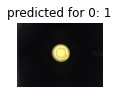

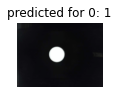

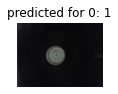

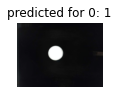

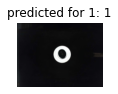

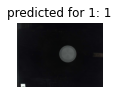

In [82]:
visualize_model(model_conv)

plt.ioff()
plt.show()